# Map DTM data on a GPS track

Pour transférer des infos du raster sur la trace

## Let's start by defining our environment

This task is only useful for the online notebook

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Let's load the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tracklib as tkl

## Load the GPS track 

The GPS track represents an extract route in Vercors

Text(901895.5667177888, 6435537.8661504565, 'E')

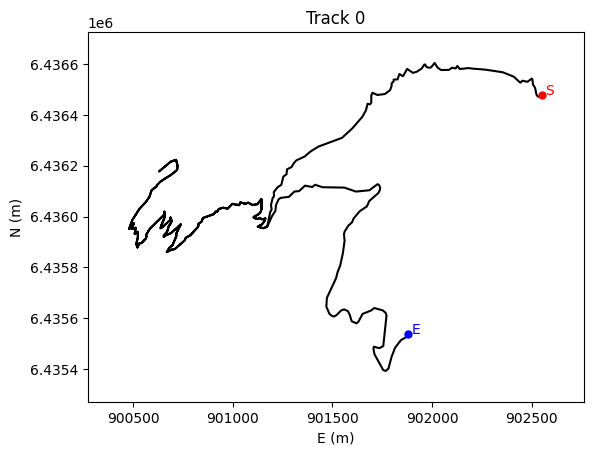

In [3]:
tkl.ObsTime.setReadFormat("4Y-2M-2D 2h:2m:2s")
resource_path = './'
filepath = os.path.join(resource_path, '../../../data/XYZBRAVOSANSFIDOUTEST.txt')
track = tkl.TrackReader.readFromCsv(filepath, 0, 1, 2, -1, h=1)
track = track[400:900]

# Display the track
track.plot()

# Display start and end of route
plt.plot(track[0].position.getX(), track[0].position.getY(), 'ro', markersize=5)
plt.text(track[0].position.getX() + 15, track[0].position.getY() + 1.1, 'S', color="red")

plt.plot(track[499].position.getX(), track[499].position.getY(), 'bo', markersize=5)
plt.text(track[499].position.getX() + 15, track[499].position.getY() + 1.1, 'E', color="blue")

## Load the tile of DTM data

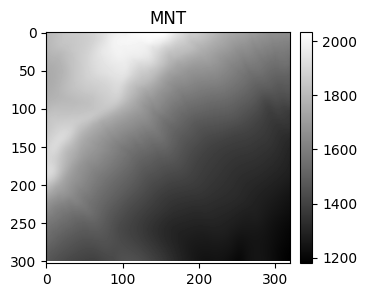

In [4]:
ascfilepath = os.path.join(resource_path, '../../../data/asc/mnt_XYZBRAVOSANSFIDOUTEST_2.asc')

raster = tkl.RasterReader.readFromAscFile(ascfilepath, 'MNT')
grid = raster.getRasterBand(0)
grid.setNoDataValue(np.nan)

grid.plotAsImage()

## Map on track and compare with the raw data

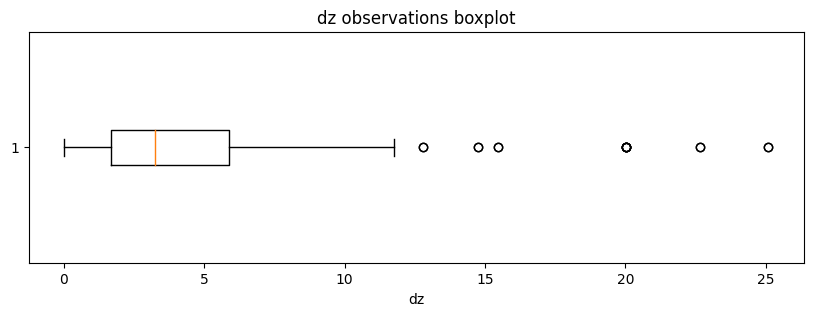

In [5]:
tkl.mapOnRaster(track, raster)

track.operate(tkl.Operator.SUBSTRACTER, "z", "MNT", "diff")
track.operate(tkl.Operator.RECTIFIER, "diff", "dz")

plot = tkl.Plot(track)
plot.plotAnalyticalFeature('dz', 'BOXPLOT')

## Final result graphic

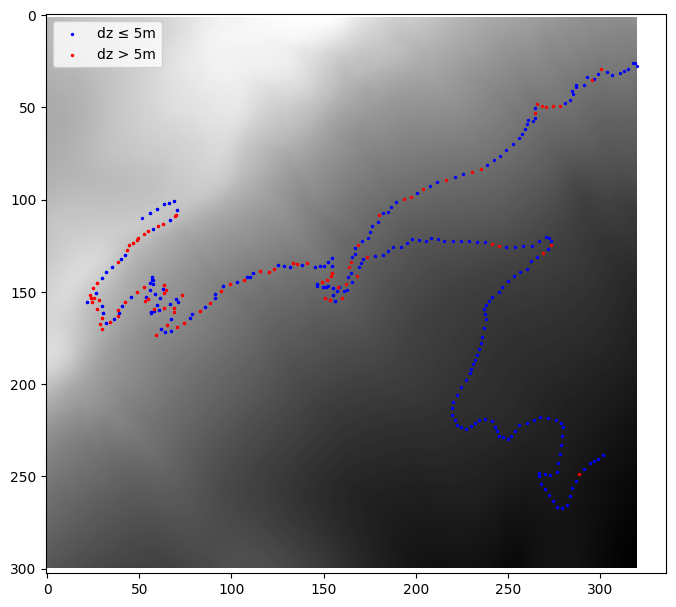

In [6]:
fig = plt.figure(figsize=(8, 8))

# Draw raster
tab = np.array(grid.grid, dtype=np.float32)
if grid.getNoDataValue() != None:
    tab[tab == grid.getNoDataValue()] = np.nan
plt.imshow(tab, cmap='gist_gray')


X1 = []
X2 = []
Y1 = []
Y2 = []
for i in range(track.size()):
    if grid.isIn(track[i].position):
        idx = (float(track[i].position.getX()) - grid.xmin) / grid.XPixelSize
        idy = (grid.nrow-1) - (float(track[i].position.getY()) - grid.ymin) / grid.YPixelSize
        if track.getObsAnalyticalFeature('dz', i) > 5:
            X2.append(idx)
            Y2.append(idy)
        else:
            X1.append(idx)
            Y1.append(idy)
plt.scatter(X1, Y1, c='blue', s=2, label='dz ≤ 5m')
plt.scatter(X2, Y2, c='red', s=2, label='dz > 5m')
plt.legend()